# Introduction to using JUNE

This notebook aims to introduce users to the JUNE pipeline and demonstrate how:(1) a world and its demography can be constructed in JUNE, (2) the epidemiology in that world can be simulated, (3) how the results from a JUNE simulation can be processed. 

Prior to running this notebook be sure to clone the JUNE repository and run ```pip install -e .``` in the root of the repository.

### Import the relevant modules

In [1]:
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path

In [2]:
from june import World 
from june.geography import Geography
from june.demography import Demography
from june.interaction import Interaction
from june.epidemiology.epidemiology import Epidemiology
from june.epidemiology.infection import Infection, InfectionSelector, InfectionSelectors
from june.epidemiology.infection.health_index import Data2Rates
from june.epidemiology.infection.health_index.health_index import HealthIndexGenerator
from june.epidemiology.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries, Universities
from june.groups.leisure import generate_leisure_for_config, Cinemas, Pubs, Groceries, Gyms
from june.groups.travel import Travel
from june.groups.travel.transport import CityTransport, CityTransports, InterCityTransport, InterCityTransports
from june.simulator import Simulator
from june.epidemiology.infection_seed import InfectionSeed, InfectionSeeds
from june.policy import Policy, Policies
from june import paths
from june.hdf5_savers import load_geography_from_hdf5
from june.records import Record, RecordReader

from june.world import generate_world_from_geography
from june.hdf5_savers import generate_world_from_hdf5

from june.tracker.tracker import Tracker

No --data argument given - defaulting to:
/home/joseph/Documents/PhD/UN_Work/JUNE-private/data
No --configs argument given - defaulting to:
/home/joseph/Documents/PhD/UN_Work/JUNE-private/june/configs


In [3]:
Results_Path = Path("results")

CONFIG_PATH = paths.configs_path / "config_example_7.yaml"
Interactions_File_Path = paths.configs_path / "defaults/interaction/interaction.yaml"
Policies_File_Path = paths.configs_path / "defaults/policy/policy.yaml"

# Creating a World

Prior to any JUNE simulation we need to construct a World. By the term 'World' we refer to a digital twin of the demography, geography and Supergroups that we want to simulate. 

Geography is captured in Regions, SuperAreas and Areas (a schema which allows JUNE simulations to operate with different topological data at different levels of granularity). Areas are the smallest geographical unit comprised of a latitude and longitude. A SuperArea is a spatially contiguous set of Areas and a SuperArea is a spatially contiguous set of Regions. Demography is responsible for the population attributes (e.g. sex, age ethnicity). Finally, SuperGroups are added, bringing, for example, households, companies and schools into our World.

To initialize a certain world, we need to add the different components we want to have in it. First we specify what SuperAreas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies. After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [4]:
%%time 

geography = Geography.from_file(
{
    "super_area": ["E02001731", "E02002566"]})

Hospitals.Get_Interaction(Interactions_File_Path)
geography.hospitals = Hospitals.for_geography(geography)

Schools.Get_Interaction(Interactions_File_Path)
geography.schools = Schools.for_geography(geography)

Companies.Get_Interaction(Interactions_File_Path)
geography.companies = Companies.for_geography(geography)

CareHomes.Get_Interaction(Interactions_File_Path)
geography.care_homes = CareHomes.for_geography(geography)

Universities.Get_Interaction(Interactions_File_Path)
geography.universities = Universities.for_geography(geography)

Households.Get_Interaction(Interactions_File_Path)

2022-09-19 16:01:54,861 - june.geography.geography - INFO - There are 67 areas and 2 super_areas and 1 regions in the world.
2022-09-19 16:01:54,898 - hospitals - INFO - There are 1 hospitals in this geography.
2022-09-19 16:01:54,979 - schools - INFO - There are 7 schools in this geography.
2022-09-19 16:01:54,990 - schools - INFO - No school for the age 0 in this world.
2022-09-19 16:01:54,992 - schools - INFO - No school for the age 1 in this world.
2022-09-19 16:01:55,013 - schools - INFO - No school for the age 12 in this world.
2022-09-19 16:01:55,015 - schools - INFO - No school for the age 13 in this world.
2022-09-19 16:01:55,592 - care_homes - INFO - There are 4 care_homes in this geography.
2022-09-19 16:01:55,650 - universities - INFO - There are 3 universities in this world.
CPU times: user 1.33 s, sys: 158 ms, total: 1.49 s
Wall time: 1.48 s


In [5]:
world = generate_world_from_geography(geography, include_households=True)

2022-09-19 16:02:04,963 - world - INFO - Populating areas
2022-09-19 16:02:05,943 - world - INFO - Areas populated. This world's population is: 19199
2022-09-19 16:02:08,448 - worker_distributor - INFO - Distributing workers to super areas...
2022-09-19 16:02:09,183 - worker_distributor - INFO - Workers distributed.
2022-09-19 16:02:10,100 - care_home_distributor - INFO - Populating care homes
2022-09-19 16:02:10,104 - care_home_distributor - INFO - This world has 78 people living in care homes.
2022-09-19 16:02:10,123 - household_distributor - INFO - Distributing people to households
2022-09-19 16:02:13,900 - household_distributor - INFO - People assigned to households. There are 9123 households in this world.
2022-09-19 16:02:13,903 - school_distributor - INFO - Distributing kids to schools
2022-09-19 16:02:13,904 - school_distributor - INFO - Distributed kids in 0 of 67 areas.
2022-09-19 16:02:14,308 - school_distributor - INFO - Kids distributed to schools
2022-09-19 16:02:14,319 -

## Configuring JUNE

We also specify the path to a config file that is important to how a JUNE simulation proceeds. Run the cell below to view the file.

We define the activities that our SuperGroups can carry out - for example, going to hospital, school etc. Further, we introduce time into our world. The `step_duration` deserves to be elaborated upon. It specifies the duration of each time step by day type - i.e. both for weekdays and weekends. According to the schema below weekdays are specified to have five time steps; a weekday starts with a one hour time step (when people commute), then 8 hours and so on. A weekend day will have three time stps of four hours and one of 12 hours. Users can modify this to add more timesteps or change the duration of a time step - the only requirement is that the duration of a day type sums to 24.

In [6]:
os.environ["CONFIG_PATH"] = str(CONFIG_PATH)
!cat $CONFIG_PATH

title: Covid configuration example

activity_to_super_groups:
  medical_facility: ["hospitals"]
  primary_activity: ['schools', 'companies', "universities"]
  leisure: ['pubs', 'cinemas', 'groceries', 'gyms', "care_home_visits", "household_visits"] 
  residence: ['households', 'care_homes']
  commute: ['city_transports', 'inter_city_transports']

time:
  total_days: 7
  initial_day: "2020-03-01 9:00" 
  step_duration: 
      weekday:
          0: 1 
          1: 8
          2: 1
          3: 3
          4: 11
      weekend:
          0: 4 
          1: 4 
          2: 4 
          3: 12 
  step_activities:
      weekday:
          0: ['medical_facility', 'residence', 'commute'] 
          1: ['medical_facility', 'primary_activity', 'leisure', 'residence'] 
          2: ['medical_facility', 'residence', 'commute'] 
          3: ['medical_facility', 'leisure', 'residence']
          4: ['medical_facility', 'residence']
      weekend:
          0: ['medical_facility', 'leisure', 'residenc

## Commute, travel and leisure

Here we add further detail to our world. Specifically, we establish what our agents can do in their world.

In [7]:
%%time

Cinemas.Get_Interaction(Interactions_File_Path)
world.cinemas = Cinemas.for_geography(geography)

Groceries.Get_Interaction(Interactions_File_Path)
world.groceries = Groceries.for_geography(geography)

Gyms.Get_Interaction(Interactions_File_Path)
world.gyms = Gyms.for_geography(geography)

Pubs.Get_Interaction(Interactions_File_Path)
world.pubs = Pubs.for_geography(geography)

leisure = generate_leisure_for_config(world, config_filename=CONFIG_PATH)
leisure.distribute_social_venues_to_areas(
    areas=world.areas, super_areas=world.super_areas
)

2022-09-19 16:02:15,822 - social_venue - INFO - Domain 0 has 2 cinemas(s)
2022-09-19 16:02:16,178 - social_venue - INFO - Domain 0 has 103 groceries(s)
2022-09-19 16:02:16,289 - social_venue - INFO - Domain 0 has 25 gyms(s)
2022-09-19 16:02:17,439 - social_venue - INFO - Domain 0 has 290 pubs(s)
2022-09-19 16:02:17,507 - leisure - INFO - Linking households and care homes for visits
2022-09-19 16:02:17,580 - leisure - INFO - Done
2022-09-19 16:02:17,581 - leisure - INFO - Distributing social venues to areas
2022-09-19 16:02:17,582 - leisure - INFO - Distributed in 0 of 67 areas.
2022-09-19 16:02:17,628 - leisure - INFO - Distributed in 67 of 67 areas.
CPU times: user 1.84 s, sys: 27.8 ms, total: 1.86 s
Wall time: 1.86 s


Now we know where everyone works in our world, we can deduce the commutes that our agents would make - for example, when going into work. This is important to the way JUNE models the spread of a disease through a population.

In [8]:
travel = Travel()

CityTransports.Get_Interaction(Interactions_File_Path)
world.city_transports = CityTransports([])
InterCityTransports.Get_Interaction(Interactions_File_Path)
world.inter_city_transports = InterCityTransports([])

travel.initialise_commute(world)

2022-09-19 16:02:17,704 - travel - INFO - Initialising commute...
2022-09-19 16:02:17,705 - travel - INFO - Creating cities...
2022-09-19 16:02:17,716 - travel - INFO - This world has 2 cities, with names
['Newcastle upon Tyne', 'Darlington']
2022-09-19 16:02:17,717 - travel - INFO - Determining people mode of transport
2022-09-19 16:02:26,204 - travel - INFO - Mode of transport allocated in 0 of 67 areas.
2022-09-19 16:02:26,246 - travel - INFO - Mode of transport determined for everyone.
2022-09-19 16:02:26,419 - travel - INFO - Assigning commuters to stations...
2022-09-19 16:02:26,420 - travel - INFO - Assigned 0 of 19199 potential commuters...
2022-09-19 16:02:26,427 - travel - INFO - Commuters assigned
2022-09-19 16:02:26,428 - travel - INFO - City Newcastle upon Tyne has 977 internal and 179 external commuters.
2022-09-19 16:02:26,434 - travel - INFO - Creating stations...
2022-09-19 16:02:26,437 - travel - INFO - City Newcastle upon Tyne has 1 city and 4 inter city stations.
20

Finally, we are also going to need some cemeteries...


In [9]:
world.cemeteries = Cemeteries()

cemetery not defined in interaction yaml or defualt options


## How to 'save the world'

If it took a long time to run the previous commands, it might be a good idea to save the world to reuse it later. Here we write the state of our World object to a file called `world.hdf5`

In [10]:
world.to_hdf5("world.hdf5")

2022-09-19 16:02:26,528 - world_saver - INFO - saving world to HDF5
2022-09-19 16:02:26,549 - world_saver - INFO - saving population...
2022-09-19 16:02:27,017 - world_saver - INFO - saving hospitals...
2022-09-19 16:02:27,023 - world_saver - INFO - saving schools...
2022-09-19 16:02:27,030 - world_saver - INFO - saving companies...
2022-09-19 16:02:27,039 - world_saver - INFO - saving households...
2022-09-19 16:02:27,195 - world_saver - INFO - saving care homes...
2022-09-19 16:02:27,200 - world_saver - INFO - saving cities...
2022-09-19 16:02:27,207 - world_saver - INFO - saving stations...
2022-09-19 16:02:27,212 - world_saver - INFO - saving universities...
2022-09-19 16:02:27,218 - world_saver - INFO - saving social venues...
2022-09-19 16:02:27,229 - world_saver - INFO - Saving domain decomposition data...


If we would like to load the world we saved, we just do:

In [11]:
world = generate_world_from_hdf5("world.hdf5")

2022-09-19 16:02:27,242 - world_saver - INFO - loading world from HDF5
2022-09-19 16:02:27,257 - world_saver - INFO - loading hospitals...
2022-09-19 16:02:27,298 - world_saver - INFO - loading schools...
2022-09-19 16:02:27,370 - company_saver - INFO - loading companies...
2022-09-19 16:02:27,372 - company_saver - INFO - Companies chunk 0 of 1
2022-09-19 16:02:27,587 - world_saver - INFO - loading care homes...
2022-09-19 16:02:27,621 - world_saver - INFO - loading universities...
2022-09-19 16:02:27,654 - world_saver - INFO - loading cities...
2022-09-19 16:02:27,659 - world_saver - INFO - loading stations...
2022-09-19 16:02:27,766 - household_saver - INFO - loading households...
2022-09-19 16:02:27,768 - household_saver - INFO - Loaded chunk 0 of 1
2022-09-19 16:02:29,787 - population saver - INFO - loading population...
2022-09-19 16:02:29,789 - population saver - INFO - Loaded chunk 0 of 1
2022-09-19 16:02:29,933 - world_saver - INFO - loading social venues...
2022-09-19 16:02:30

Note: if we load the world from a file we have to regenerate the leisure object that draws on information in the world:

In [12]:
leisure = generate_leisure_for_config(world, CONFIG_PATH)

Similarly, a travel object must also be redefined:

In [13]:
travel = Travel()

You have now a beautiful pre-pandemic world. 

# Adding the infection

The module in charge of infecting people is called the ``InfectionSelector``, which gives people a transmission time profile and a symptoms trajectory based on their age and sex (through the health index generator). We can have multiple infection selectors for multiple infections, but we stick to one for now.

In [14]:
selector = InfectionSelector.from_file()
selectors = InfectionSelectors([selector])

The other ingredient we need is a way to seed a few initial infections. This is done through the InfectionSeed class. As with the selectors, we can have multiple infection seeds operating at different times. There are multiple implemented methods to seed an infection, but for now we'll stick to a simple uniform distribution of cases

In [15]:
infection_seed = InfectionSeed.from_uniform_cases(
    world=world, infection_selector=selector, cases_per_capita=0.01, date="2020-03-01 9:00", seed_past_infections=False,
)
infection_seeds = InfectionSeeds([infection_seed])

All the functionality related to infections is handled by the Epidemiology class.

In [16]:
epidemiology = Epidemiology(infection_selectors=selectors, infection_seeds=infection_seeds)

# Adding the interaction

June models human-to-human transmissible diseases. The model, therefore, needs information about the interactions between its agents. We read this out of a config file: `june/configs/defaults/interaction/interaction.yaml`

In [17]:
interaction = Interaction.from_file(
    config_filename=Interactions_File_Path
)

Betas are the intensities of the interaction taking place at the different groups

In [18]:
interaction.betas

{'pub': 0.42941,
 'gym': 0.42941,
 'grocery': 0.04137,
 'cinema': 0.157461,
 'city_transport': 0.107969,
 'inter_city_transport': 0.383,
 'hospital': 0.1168,
 'care_home': 0.28,
 'company': 0.371,
 'school': 0.07,
 'household': 0.208,
 'household_visits': 0.208,
 'care_visits': 0.208,
 'university': 0.306}

Moreover, this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [19]:
interaction.alpha_physical

2.0

# Set policies

JUNE's policy layer allows users to experiment with policy measures designed to control and redice the impact of human to human transmissible diseases. These might include social distancing measures, the closure of schools or restaurants and much more. Since JUNE has highly granular layers of geographical knowledge, policies can be tested on regional levels or even in relation to specific individuals and venues.

Here we load in the set of policies captured in `june/configs/defaults/policy/policy.yaml`

In [20]:
policies = Policies.from_file()

We can have a look at one of the policies

In [21]:
print(policies.individual_policies[8].__dict__)

{'spec': 'close_companies', 'start_time': datetime.datetime(2020, 3, 16, 0, 0), 'end_time': datetime.datetime(2020, 3, 20, 0, 0), 'policy_type': 'individual', 'policy_subtype': 'skip_activity', 'activities_to_remove': ('primary_activity', 'commute'), 'full_closure': False, 'avoid_work_probability': 0.2, 'furlough_probability': 0.04, 'key_probability': 0.22}


# Define a contact Tracker

We define a list of venues in which to track. This is fed into JUNE's tracker class. We can specify tracking contacts by sex, the type of possible contacts "1D" (simulated contacts based on the input interaction matrices) or "All" (everyone at each venue contacts each other). Lastly we can find a subset of venues upto N but defining MaxVenueTrackingSize=N.

In [22]:
group_types=[
    world.households,
    world.care_homes,
    world.schools,
    world.hospitals,
    world.companies,
    world.universities,
    world.pubs,
    world.groceries,
    world.cinemas,
    world.gyms,
    world.city_transports,
    world.inter_city_transports,
]

tracker = Tracker(
    world=world,
    record_path=Results_Path,
    group_types=group_types,
    load_interactions_path=Interactions_File_Path,
    contact_sexes=["unisex", "male", "female"],
    MaxVenueTrackingSize = 500
)

# Run the simulation

The first thing we need is a place to save our simulation results. For that we can use the record class, and pass it to the simulator.

In [23]:
record = Record(    
    record_path = Results_Path,    
    record_static_data=True,
) 

The simulator is the main module in charge of running the simulation. It coordinates the ``ActivityManager`` which is responsible of allocating people to the right groups given the current timestep, it updates the health status of the population, and it runs the interaction over the different groups. All of these modules can be modified by policies at any given time.

Since the timer configuration is a bit cumbersome, it is read from the config file at https://github.com/IDAS-Durham/JUNE/blob/master/june/configs/config_example.yaml

In [24]:
simulator = Simulator.from_file(
    world=world,
    epidemiology=epidemiology,
    interaction=interaction, 
    config_filename = CONFIG_PATH,
    leisure = leisure,
    travel = travel,
    record=record,
    policies = policies,
    tracker=tracker,
)

In [25]:
%%time
simulator.run()

2022-09-19 16:02:31,858 - simulator - INFO - Starting simulation for 7 days at day 2020-03-01 09:00:00,to run for 7 days
2022-09-19 16:02:32,339 - seed - INFO - Seeding Covid19 infections at date 2020-03-01
2022-09-19 16:02:32,713 - rank - INFO - Next timestep
2022-09-19 16:02:32,714 - simulator - INFO - ==================== timestep ====================
2022-09-19 16:02:33,273 - rank - INFO - Rank 0 -- move_people -- 0.5579224370012525
2022-09-19 16:02:33,275 - rank - INFO - Rank 0 -- move_people_waiting -- 9.078008588403463e-06
2022-09-19 16:02:33,276 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.989000106230378e-06,3.5762786865234375e-06 - 2020-03-01 09:00:00
2022-09-19 16:02:33,280 - simulator - INFO - Info for rank 0, Date = 2020-03-01 09:00:00, number of deaths =  0, number of infected = 193
2022-09-19 16:02:33,389 - rank - INFO - Rank 0 -- interaction -- 0.11171430599642918
2022-09-19 16:02:33,390 - tracker - INFO - Rank 0 -- tracking contacts -- 1 of 1 of type h

2022-09-19 16:02:36,925 - tracker - INFO - Rank 0 -- tracking contacts -- 4 of 4 of type care_home
2022-09-19 16:02:36,939 - tracker - INFO - Rank 0 -- tracking contacts -- 7 of 7 of type school
2022-09-19 16:02:36,944 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 1875 of type company
2022-09-19 16:02:36,952 - tracker - INFO - Rank 0 -- tracking contacts -- 3 of 3 of type university
2022-09-19 16:02:36,953 - tracker - INFO - Rank 0 -- tracking contacts -- 45 of 45 of type city_transport
2022-09-19 16:02:36,955 - tracker - INFO - Rank 0 -- tracking contacts -- 9 of 9 of type inter_city_transport
2022-09-19 16:02:36,958 - tracker - INFO - Rank 0 -- tracking contacts -- 290 of 290 of type pub
2022-09-19 16:02:36,964 - tracker - INFO - Rank 0 -- tracking contacts -- 2 of 2 of type cinema
2022-09-19 16:02:36,965 - tracker - INFO - Rank 0 -- tracking contacts -- 103 of 103 of type grocery
2022-09-19 16:02:36,968 - tracker - INFO - Rank 0 -- tracking contacts -- 25 of 25 of type gy

2022-09-19 16:02:48,196 - rank - INFO - Rank 0 -- interaction_waiting -- 6.990012479946017e-06
2022-09-19 16:02:48,216 - simulator - INFO - CMS: Timestep for rank 0/1 - 3.6196397919993615,3.6196413040161133 - 2020-03-02 18:00:00

2022-09-19 16:02:48,218 - rank - INFO - Next timestep
2022-09-19 16:02:48,219 - simulator - INFO - ==================== timestep ====================
2022-09-19 16:02:48,656 - rank - INFO - Rank 0 -- move_people -- 0.43554977199528366
2022-09-19 16:02:48,656 - rank - INFO - Rank 0 -- move_people_waiting -- 7.580005330964923e-06
2022-09-19 16:02:48,657 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.6999990697950125e-06,3.0994415283203125e-06 - 2020-03-02 19:00:00
2022-09-19 16:02:48,661 - simulator - INFO - Info for rank 0, Date = 2020-03-02 19:00:00, number of deaths =  0, number of infected = 223
2022-09-19 16:02:48,801 - rank - INFO - Rank 0 -- interaction -- 0.1431842960009817
2022-09-19 16:02:51,998 - tracker - INFO - Rank 0 -- tracking cont

2022-09-19 16:03:02,068 - tracker - INFO - Rank 0 -- tracking contacts -- 4 of 4 of type care_home
2022-09-19 16:03:02,088 - tracker - INFO - Rank 0 -- tracking contacts -- 7 of 7 of type school
2022-09-19 16:03:02,708 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 1875 of type company
2022-09-19 16:03:03,139 - tracker - INFO - Rank 0 -- tracking contacts -- 3 of 3 of type university
2022-09-19 16:03:05,894 - tracker - INFO - Rank 0 -- tracking contacts -- 45 of 45 of type city_transport
2022-09-19 16:03:05,896 - tracker - INFO - Rank 0 -- tracking contacts -- 9 of 9 of type inter_city_transport
2022-09-19 16:03:05,898 - tracker - INFO - Rank 0 -- tracking contacts -- 290 of 290 of type pub
2022-09-19 16:03:05,956 - tracker - INFO - Rank 0 -- tracking contacts -- 2 of 2 of type cinema
2022-09-19 16:03:05,962 - tracker - INFO - Rank 0 -- tracking contacts -- 103 of 103 of type grocery
2022-09-19 16:03:06,030 - tracker - INFO - Rank 0 -- tracking contacts -- 25 of 25 of type gy

2022-09-19 16:03:17,868 - rank - INFO - Rank 0 -- interaction_waiting -- 6.656002369709313e-06
2022-09-19 16:03:17,887 - simulator - INFO - CMS: Timestep for rank 0/1 - 4.114530824997928,4.1145312786102295 - 2020-03-03 22:00:00

2022-09-19 16:03:17,890 - rank - INFO - Next timestep
2022-09-19 16:03:17,891 - simulator - INFO - ==================== timestep ====================
2022-09-19 16:03:17,986 - rank - INFO - Rank 0 -- move_people -- 0.09440028900280595
2022-09-19 16:03:17,987 - rank - INFO - Rank 0 -- move_people_waiting -- 6.043002940714359e-06
2022-09-19 16:03:17,988 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.139001248404384e-06,3.814697265625e-06 - 2020-03-04 09:00:00
2022-09-19 16:03:17,993 - simulator - INFO - Info for rank 0, Date = 2020-03-04 09:00:00, number of deaths =  0, number of infected = 279
2022-09-19 16:03:18,096 - rank - INFO - Rank 0 -- interaction -- 0.1070410950051155
2022-09-19 16:03:21,600 - tracker - INFO - Rank 0 -- tracking contacts -

2022-09-19 16:03:34,352 - tracker - INFO - Rank 0 -- tracking contacts -- 4 of 4 of type care_home
2022-09-19 16:03:34,370 - tracker - INFO - Rank 0 -- tracking contacts -- 7 of 7 of type school
2022-09-19 16:03:34,379 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 1875 of type company
2022-09-19 16:03:34,391 - tracker - INFO - Rank 0 -- tracking contacts -- 3 of 3 of type university
2022-09-19 16:03:34,395 - tracker - INFO - Rank 0 -- tracking contacts -- 45 of 45 of type city_transport
2022-09-19 16:03:34,399 - tracker - INFO - Rank 0 -- tracking contacts -- 9 of 9 of type inter_city_transport
2022-09-19 16:03:34,402 - tracker - INFO - Rank 0 -- tracking contacts -- 290 of 290 of type pub
2022-09-19 16:03:34,586 - tracker - INFO - Rank 0 -- tracking contacts -- 2 of 2 of type cinema
2022-09-19 16:03:34,596 - tracker - INFO - Rank 0 -- tracking contacts -- 103 of 103 of type grocery
2022-09-19 16:03:34,738 - tracker - INFO - Rank 0 -- tracking contacts -- 25 of 25 of type gy

2022-09-19 16:03:48,766 - rank - INFO - Rank 0 -- interaction_waiting -- 9.019000572152436e-06
2022-09-19 16:03:48,784 - simulator - INFO - CMS: Timestep for rank 0/1 - 5.17122296000889,5.171224117279053 - 2020-03-05 10:00:00

2022-09-19 16:03:48,787 - rank - INFO - Next timestep
2022-09-19 16:03:48,788 - simulator - INFO - ==================== timestep ====================
2022-09-19 16:03:48,880 - rank - INFO - Rank 0 -- move_people -- 0.09063528900151141
2022-09-19 16:03:48,881 - rank - INFO - Rank 0 -- move_people_waiting -- 7.350012310780585e-06
2022-09-19 16:03:48,881 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.5099947126582265e-06,3.0994415283203125e-06 - 2020-03-05 18:00:00
2022-09-19 16:03:48,886 - simulator - INFO - Info for rank 0, Date = 2020-03-05 18:00:00, number of deaths =  0, number of infected = 370
2022-09-19 16:03:48,998 - rank - INFO - Rank 0 -- interaction -- 0.11598719700123183
2022-09-19 16:03:51,604 - tracker - INFO - Rank 0 -- tracking contac

2022-09-19 16:04:04,824 - tracker - INFO - Rank 0 -- tracking contacts -- 4 of 4 of type care_home
2022-09-19 16:04:04,836 - tracker - INFO - Rank 0 -- tracking contacts -- 7 of 7 of type school
2022-09-19 16:04:04,843 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 1875 of type company
2022-09-19 16:04:04,855 - tracker - INFO - Rank 0 -- tracking contacts -- 3 of 3 of type university
2022-09-19 16:04:04,860 - tracker - INFO - Rank 0 -- tracking contacts -- 45 of 45 of type city_transport
2022-09-19 16:04:05,027 - tracker - INFO - Rank 0 -- tracking contacts -- 9 of 9 of type inter_city_transport
2022-09-19 16:04:05,059 - tracker - INFO - Rank 0 -- tracking contacts -- 290 of 290 of type pub
2022-09-19 16:04:05,064 - tracker - INFO - Rank 0 -- tracking contacts -- 2 of 2 of type cinema
2022-09-19 16:04:05,066 - tracker - INFO - Rank 0 -- tracking contacts -- 103 of 103 of type grocery
2022-09-19 16:04:05,068 - tracker - INFO - Rank 0 -- tracking contacts -- 25 of 25 of type gy

2022-09-19 16:04:17,848 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1067997547797859e-05
2022-09-19 16:04:17,877 - simulator - INFO - CMS: Timestep for rank 0/1 - 3.978313284998876,3.978314161300659 - 2020-03-06 19:00:00

2022-09-19 16:04:17,880 - rank - INFO - Next timestep
2022-09-19 16:04:17,881 - simulator - INFO - ==================== timestep ====================
2022-09-19 16:04:17,962 - rank - INFO - Rank 0 -- move_people -- 0.07913316499616485
2022-09-19 16:04:17,962 - rank - INFO - Rank 0 -- move_people_waiting -- 6.520000169984996e-06
2022-09-19 16:04:17,963 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.278998287394643e-06,5.245208740234375e-06 - 2020-03-06 22:00:00
2022-09-19 16:04:17,967 - simulator - INFO - Info for rank 0, Date = 2020-03-06 22:00:00, number of deaths =  0, number of infected = 455
2022-09-19 16:04:18,096 - rank - INFO - Rank 0 -- interaction -- 0.13141389499651268
2022-09-19 16:04:21,757 - tracker - INFO - Rank 0 -- tracking contac

2022-09-19 16:04:30,332 - tracker - INFO - Rank 0 -- tracking contacts -- 4 of 4 of type care_home
2022-09-19 16:04:30,350 - tracker - INFO - Rank 0 -- tracking contacts -- 7 of 7 of type school
2022-09-19 16:04:30,357 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 1875 of type company
2022-09-19 16:04:30,366 - tracker - INFO - Rank 0 -- tracking contacts -- 3 of 3 of type university
2022-09-19 16:04:30,367 - tracker - INFO - Rank 0 -- tracking contacts -- 45 of 45 of type city_transport
2022-09-19 16:04:30,369 - tracker - INFO - Rank 0 -- tracking contacts -- 9 of 9 of type inter_city_transport
2022-09-19 16:04:30,371 - tracker - INFO - Rank 0 -- tracking contacts -- 290 of 290 of type pub
2022-09-19 16:04:30,507 - tracker - INFO - Rank 0 -- tracking contacts -- 2 of 2 of type cinema
2022-09-19 16:04:30,512 - tracker - INFO - Rank 0 -- tracking contacts -- 103 of 103 of type grocery
2022-09-19 16:04:30,620 - tracker - INFO - Rank 0 -- tracking contacts -- 25 of 25 of type gy

# Getting the results

The record saves a lot of information about the simulation, and it can be a bit overwhelming to look at everyting.
In the results folder (if you didn't change the path), we have a few extra contents:


In [26]:
!ls results

checkpoints  config.yaml  june_record.h5  policies.json  summary.csv  Tracker


Checkpoints would allow us to resume the simulation later, and the config and policies are there to remember what you used to run the code.
The ``summary.csv`` is useful to have a first glance at results:

In [27]:
summary = pd.read_csv(Results_Path / "summary.csv", index_col=0)
summary.head()

,region,current_infected,daily_infected,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,
2020-03-01,North East,193,193,0,0,0,0,0,0
2020-03-01,North East,195,2,0,0,0,0,0,0
2020-03-01,North East,199,4,0,0,0,0,0,0
2020-03-01,North East,210,11,0,0,0,0,0,0
2020-03-02,North East,212,2,0,0,0,0,0,0


<AxesSubplot:xlabel='time_stamp'>

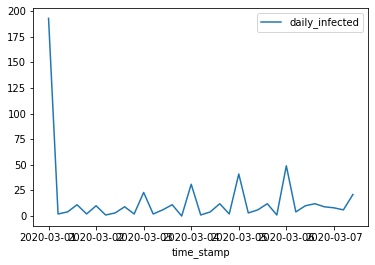

In [28]:
summary.plot(y="daily_infected")

If we want to get the full details, we can read the record:

In [29]:
read = RecordReader("." / Results_Path)

In [30]:
read.regional_summary.head(3) # this is the equivalent of the summary.csv

,region,current_infected,daily_infected,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,
2020-03-01,North East,199.25,210,0.0,0,0.0,0,0,0
2020-03-02,North East,223.60,25,0.0,0,0.0,0,0,0
2020-03-03,North East,261.20,44,0.0,0,0.0,0,0,0


# Asking questions to the records

## Useful infections and death tables

In [31]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2022-09-19 16:04:33,501 - june.records.records_reader - INFO - Loading infections table
2022-09-19 16:04:33,511 - june.records.records_reader - INFO - Loading population table
2022-09-19 16:04:33,568 - june.records.records_reader - INFO - Merging infection and population tables
2022-09-19 16:04:33,575 - june.records.records_reader - INFO - Loading geography table
2022-09-19 16:04:33,598 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [32]:
infections_df.head(10)

,timestamp,location_ids,infector_ids,infection_ids,location_specs,region_names,age,primary_activity_id,residence_id,area_id,sex,ethnicity,primary_activity_type,residence_type,super_area_id,name_area,region_id,name_super_area,name_region
1974,2020-03-01,0,1974,170852960,infection_seed,North East,0,0,990,7,f,C1,None,household,0,E00042585,0,E02001731,North East
2087,2020-03-01,0,2087,170852960,infection_seed,North East,26,1306,981,7,f,A1,company,household,0,E00042585,0,E02001731,North East
2179,2020-03-01,393,5713,170852960,grocery,North East,58,1305,969,7,f,A1,company,household,0,E00042585,0,E02001731,North East
2078,2020-03-03,2,5297,170852960,university,North East,24,2,1012,7,m,A1,university,household,0,E00042585,0,E02001731,North East
2088,2020-03-03,990,1974,170852960,household,North East,27,0,990,7,m,D1,company,household,0,E00042585,0,E02001731,North East
2163,2020-03-04,1326,15269,170852960,company,North East,51,1326,1013,7,f,A1,company,household,0,E00042585,0,E02001731,North East
2032,2020-03-05,990,1974,170852960,household,North East,12,0,990,7,m,A1,None,household,0,E00042585,0,E02001731,North East
2192,2020-03-06,0,7392,170852960,hospital,North East,64,0,1041,7,f,A1,hospital,household,0,E00042585,0,E02001731,North East
2104,2020-03-06,7,264,170852960,company,North East,32,7,1007,7,f,A1,company,household,0,E00042585,0,E02001731,North East
2128,2020-03-06,7,5548,170852960,company,North East,38,7,1021,7,m,A1,company,household,0,E00042585,0,E02001731,North East


In [33]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2022-09-19 16:04:33,698 - june.records.records_reader - INFO - Loading deaths table
2022-09-19 16:04:33,704 - june.records.records_reader - INFO - Loading population table
2022-09-19 16:04:33,749 - june.records.records_reader - INFO - Merging infection and population tables
2022-09-19 16:04:33,753 - june.records.records_reader - INFO - Loading geography table
2022-09-19 16:04:33,776 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [34]:
deaths_df.head(10)

,timestamp,location_ids,location_specs,age,primary_activity_id,residence_id,area_id,sex,ethnicity,primary_activity_type,residence_type,super_area_id,name_area,region_id,name_super_area,name_region
id,,,,,,,,,,,,,,,,


## Sero-prevalence by age

In [35]:
age_bins = (0,20,60,100)

In [36]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [37]:
people_df = read.table_to_df('population')

In [38]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

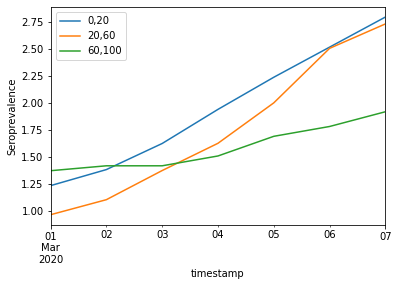

In [39]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.ylabel("Seroprevalence")
plt.legend()

## Care home deaths in hospital

In [40]:
care_home_deaths_hospital = deaths_df[
    (deaths_df['location_specs'] == 'hospital') 
    & (deaths_df['residence_type'] == 'care_home')
]
care_home_deaths_hospital=care_home_deaths_hospital.groupby(
    ['name_region', 'timestamp']
).size()

In [41]:
try:
    care_home_deaths_hospital.unstack(level=0).plot()
except TypeError:
    print("this may fail if your simulation doesn't have care home deaths")

this may fail if your simulation doesn't have care home deaths


## Where people get infected as a function of time

In [42]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

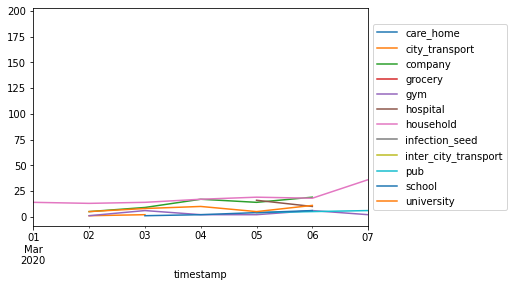

In [43]:
ax = locations_df.unstack(level=0).plot()
ax.legend(loc="center left", bbox_to_anchor=(1,0.5))

Text(0.5, 0, 'location')

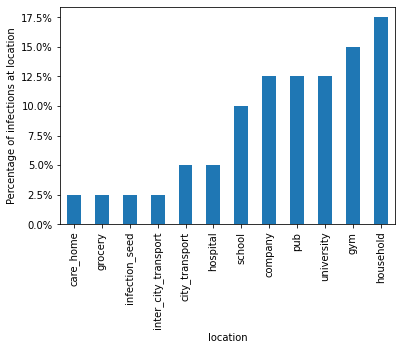

In [44]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')


## Where people of certain age get infected as a function of time

In [45]:
old_locations_df = infections_df[
    infections_df.age > 65
].groupby(['location_specs', 'timestamp']).size()

<AxesSubplot:xlabel='timestamp'>

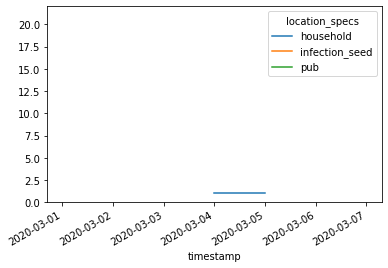

In [46]:
old_locations_df.unstack(level=0).plot()

## How many households have everyone infected?

In [47]:
n_infected_by_household = infections_df[
    infections_df['residence_type'] == 'household'
].groupby('residence_id').size()

In [48]:
residence_id = []
n_residents = []
for household in world.households:
    residence_id.append(household.id)
    n_residents.append(household.n_residents)
household_people = pd.DataFrame({"residence_id":residence_id, "n_residents":n_residents})

In [49]:
n_total_in_household = household_people[
    household_people['residence_id'].isin(
        n_infected_by_household.index
    )
]['n_residents']

Text(0.5, 0, '% of the household infected')

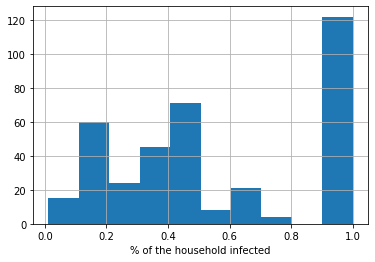

In [50]:
(n_infected_by_household/n_total_in_household).hist()
plt.xlabel('% of the household infected')

## Percentage of infected per care home

In [51]:
n_infected_by_carehome = infections_df[
    infections_df['residence_type'] == 'care_home'
].groupby(
    'residence_id'
).size()

In [52]:
n_total_in_carehome = people_df[
    (people_df['residence_type'] == 'care_home') 
    & (people_df['residence_id'].isin(n_infected_by_carehome.index))  
].groupby('residence_id').size()

Text(0.5, 0, '% of the care home infected')

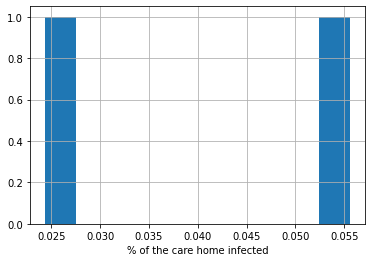

In [53]:
(n_infected_by_carehome/n_total_in_carehome).hist()
plt.xlabel('% of the care home infected')

In [54]:
# from all care homes, how many got at least one case?

In [55]:
n_total_care_homes = people_df[
    (people_df['residence_type'] == 'care_home') 
]['residence_id'].nunique()

In [56]:
n_total_care_homes

4

In [57]:
care_homes_with_infected = infections_df[
    (infections_df['residence_type'] == 'care_home') 
]['residence_id'].nunique()

In [58]:
care_homes_with_infected/n_total_care_homes

0.5

# Tracker results

We can define custom binnings with bin edges as such.

In [59]:
simulator.tracker.contract_matrices("AC", np.array([0,18,60]))
simulator.tracker.contract_matrices("Paper",[0,5,10,13,15,18,20,22,25,30,35,40,45,50,55,60,65,70,75,100])

1

Lastly we call the tracker to save the results to file and provide a print out of the results.

In [60]:
simulator.tracker.post_process_simulation(save=True)

/home/joseph/Documents/PhD/UN_Work/JUNE-private/june/tracker/tracker.py:1394: RuntimeWarning: divide by zero encountered in double_scalars
  w = pop_tots[j] / pop_tots[i]
/home/joseph/Documents/PhD/UN_Work/JUNE-private/june/tracker/tracker.py:1394: RuntimeWarning: invalid value encountered in double_scalars
  w = pop_tots[j] / pop_tots[i]


Results from UNCM
  hospital:
    contacts: [[5.1426,4.1114,0.0000],[0.2031,0.0000,0.0000],[0.0000,0.0000,0.0000]]
    contacts_err: [[0.1007,0.0900,0.0000],[0.0908,0.0000,0.0000],[0.0000,0.0000,0.0000]]
    proportion_physical: [[0.0500,1.0000,1.0000],[1.0000,0.0000,0.0000],[1.0000,0.0000,0.0000]]
    characteristic_time: 8.00

    Ratio of contacts and feed in values: [[1.0285,0.4111,0.0000],[0.2031,0.0000,0.0000],[0.0000,0.0000,0.0000]]

  care_home:
    contacts: [[18.6384,21.3683,0.0000],[0.3152,3.9319,0.0244],[0.0000,15.6889,0.0000]]
    contacts_err: [[1.3246,1.4183,0.0000],[0.0243,0.0859,0.0068],[0.0000,4.9613,0.0000]]
    proportion_physical: [[0.0500,1.0000,0.0000],[1.0000,0.0000,0.1000],[0.0000,0.1000,0.0000]]
    characteristic_time: 24.00

    Ratio of contacts and feed in values: [[1.2426,1.4246,0.0000],[0.2101,0.9830,0.0244],[0.0000,0.7844,0.0000]]

  company:
    contacts: [[4.7966]]
    contacts_err: [[0.0203]]
    proportion_physical: [[0.0700]]
    characteristic_tim

/home/joseph/Documents/PhD/UN_Work/JUNE-private/june/tracker/tracker.py:3035: RuntimeWarning: invalid value encountered in true_divide
  % self.MatrixString(contact / np.array(im))
/home/joseph/Documents/PhD/UN_Work/JUNE-private/june/tracker/tracker.py:3035: RuntimeWarning: divide by zero encountered in true_divide
  % self.MatrixString(contact / np.array(im))
/home/joseph/Documents/PhD/UN_Work/JUNE-private/june/tracker/tracker.py:409: RuntimeWarning: divide by zero encountered in true_divide
  P = np.nan_to_num(cm / np.nansum(cm, axis=1), nan=0.0)
/home/joseph/Documents/PhD/UN_Work/JUNE-private/june/tracker/tracker.py:409: RuntimeWarning: invalid value encountered in true_divide
  P = np.nan_to_num(cm / np.nansum(cm, axis=1), nan=0.0)
/home/joseph/Documents/PhD/UN_Work/JUNE-private/june/tracker/tracker.py:392: RuntimeWarning: invalid value encountered in true_divide
  DM = abs(x - y) / (abs(x) + abs(y))


1

In [69]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors

# bin_type = "syoa"
# sex = "unisex"
# contact_type = "school"

# ratio = (simulator.tracker.location_cum_pop[bin_type][contact_type][sex] / simulator.tracker.location_cum_pop[bin_type]["global"][sex])
# UNCM = np.array(simulator.tracker.UNCM[bin_type][contact_type][sex])
# UNCM_R = np.array(simulator.tracker.UNCM[bin_type][contact_type][sex])


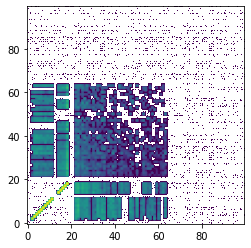

In [72]:
# ratio = simulator.tracker.AttendenceRatio(bin_type, contact_type, "unisex")
# cm = simulator.tracker.UNtoPNConversion(UNCM_R, ratio)

# plt.imshow(cm,origin="lower", norm=colors.LogNorm())